## Final Project Submission

Please fill out:
* Student name: Sam Stoltenberg
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: James Irving
* Blog post URL:


In [1]:
# Relevant imports
import os
import pandas as pd
import pandasql as ps
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)

C:\Users\12147\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
store_folder = 'Data'
data = {}  # dictionary of dataframes
total_size = 0  # size of all of the files
for filename in os.listdir(store_folder):
    path = (store_folder+'/'+filename)
    size = os.stat(path).st_size/(1024**2)  # gets the size of the file in MB
    total_size += size
    print("reading", filename, size, 'MB')
    try:
        if path.endswith('tsv.gz'):  # for tsv files
            data[filename[:-7]] = pd.read_csv(path,
                                                delimiter='\t',
                                                low_memory=False)
        else:  # for csv files
            data[filename[:-7]] = pd.read_csv(path,
                                                low_memory=False)
    except UnicodeDecodeError:
        # Changing encoding to reflect utf-8 unknown characters
        if path.endswith('tsv.gz'):
            data[filename[:-7]] = pd.read_csv(path,
                                            delimiter='\t',
                                            low_memory=False,
                                            encoding='windows-1252')
        else:
            data[filename[:-7]] = pd.read_csv(path,
                                            low_memory=False,
                                            encoding='windows-1252')
print('Done loading %s MB' % total_size)

reading imdb.name.basics.tsv.gz 190.70305347442627 MB
reading imdb.title.akas.tsv.gz 189.05681037902832 MB
reading imdb.title.basics.tsv.gz 119.10677146911621 MB
reading imdb.title.crew.tsv.gz 47.09960460662842 MB
reading imdb.title.episode.tsv.gz 26.076172828674316 MB
reading imdb.title.principals.tsv.gz 314.29254722595215 MB
reading imdb.title.ratings.tsv.gz 4.99261474609375 MB
Done loading 891.3275747299194 MB


In [3]:
# Open df from csv that was scraped as a group
data['scraped_money'] = pd.read_csv('scraped_data/budget_ratings.csv', index_col=0)

In [4]:
# Loading each of the csv/tsv files into variables for pysql
# Showing the columns for each for reference

['nconst', 'primaryName', 'birthYear', 'deathYear', 'primaryProfession', 'knownForTitles']
name_basics = data['imdb.name.basics']

['titleId', 'ordering', 'title', 'region', 'language', 'types',
    'attributes', 'isOriginalTitle']
title_akas = data['imdb.title.akas']

['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
    'startYear', 'endYear', 'runtimeMinutes', 'genres']
title_basics = data['imdb.title.basics']

['tconst', 'directors', 'writers']
title_crew = data['imdb.title.crew']

['tconst', 'parentTconst', 'seasonNumber', 'episodeNumber']
title_episode = data['imdb.title.episode']

['tconst', 'ordering', 'nconst', 'category', 'job', 'characters']
title_principals = data['imdb.title.principals']

['tconst', 'averageRating', 'numVotes']
title_ratings = data['imdb.title.ratings']

['tconst', 'budget', 'ww_gross', 'rating']
scraped_money = data['scraped_money']

In [5]:
# Setting the index of scraped_money to match the rest
scraped_money = scraped_money.set_index('tconst')

In [6]:
# Taking out the top ratings that have needed values(budget, gross, etc)
# Cleaning ratings below, because of genres in rating column
df = scraped_money
ratings = ['G', 'PG', 'PG-13', 'R']
df['rating'].value_counts().head(10)

NotRated       5834
R              2272
PG-13          1265
TV-MA           949
Drama           871
Documentary     811
TV-14           760
PG              723
Unrated         663
Comedy          573
Name: rating, dtype: int64

In [7]:
# Cleaning up scraped money to remove zeros and null values
# Setting each relevent column to integers
df['rating'] = df['rating'].map(lambda x: np.NaN if x not in ratings else x)
df['budget'] = df['budget'].map(lambda x: np.NaN if x in[None, 0, '0'] else x)
df['gross'] = df['gross'].map(lambda x: np.NaN if x in[None, 0, '0'] else x)
df['ww_gross'] = df['ww_gross'].map(lambda x: np.NaN if x in[None, 0] else x)
df = df.dropna()
df['budget'] = df['budget'].astype('int64')
df['ww_gross'] = df['ww_gross'].astype('int64')
df['gross'] = df['gross'].astype('int64')
df

,budget,gross,ww_gross,rating
tconst,,,,
tt3567288,5000000,65206105,98450062,PG-13
tt3569230,30000000,1872994,42972994,R
tt3576728,30000000,490973,3087832,PG-13
tt3602422,1310000,38901,38901,R
tt3605418,2500000,36336,5567103,R
...,...,...,...,...
tt1605803,9000000,27000,27000,PG-13
tt1606378,92000000,67349198,304654182,R
tt1606389,30000000,125014030,196114570,PG-13


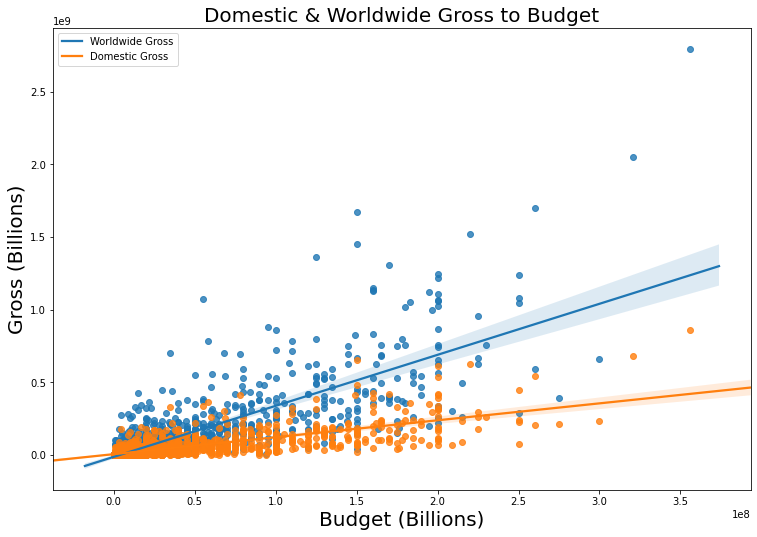

In [8]:
# Which is more profitable, domestic or worldwide markets?
new_df = df.copy(deep=True)[0:100]

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12.5, 8.5))
sns.regplot("budget", "ww_gross", data=df, ax=ax)
sns.regplot("budget", "gross", data=df, ax=ax)

ax.legend(["Worldwide Gross", "Domestic Gross"])
ax.set_title("Domestic & Worldwide Gross to Budget")
ax.title.set_fontsize(20)
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.xaxis.label.set_text("Budget (Billions)")
ax.yaxis.label.set_text("Gross (Billions)")

# As you can see, movies that are worldwide make more money than domestic movies

In [9]:
# Take df(scraped_money) and add a column with the % difference of budget-> ww_gross
# i.e ROI % (Return on investment %)
def compare(budget, gross):
    net = gross - budget
    return net/budget
df['perc'] = compare(df['budget'], df['ww_gross'])
df.sort_values(by='perc', ascending=False)


,budget,gross,ww_gross,rating,perc
tconst,,,,,
tt1560985,1000000,53261944,101758490,R,100.758490
tt7668870,880000,26020957,75462037,PG-13,84.752315
tt1591095,1500000,54009150,99557032,PG-13,65.371355
tt3713166,1000000,32482090,62882090,R,61.882090
tt5052448,4500000,176040665,272495873,R,59.554638
...,...,...,...,...,...
tt5303442,20000000,11255,11255,R,-0.999437
tt4414438,18000000,7162,7162,R,-0.999602
tt0762138,2500000,663,663,R,-0.999735


In [10]:
q1 = """
SELECT DISTINCT tconst, primaryTitle, genres, budget, ww_gross, rating, perc, runtimeMinutes, directors, writers
FROM df
JOIN title_basics tb
USING(tconst)
JOIN title_crew tc
USING(tconst)
JOIN title_akas ta
ON tconst = titleId
"""

In [11]:
# Join directors, writers, runtime, title, and genres to my scraped dataframe on 'tconst'.
called_df = ps.sqldf(q1, locals())
called_df

,tconst,primaryTitle,genres,budget,ww_gross,rating,perc,runtimeMinutes,directors,writers
0,tt0326965,In My Sleep,"Drama,Mystery,Thriller",1000000,30158,PG-13,-0.969842,104,nm1075006,nm1075006
1,tt0337692,On the Road,"Adventure,Drama,Romance",25000000,9617377,R,-0.615305,124,nm0758574,"nm0449616,nm1433580"
2,tt0359950,The Secret Life of Walter Mitty,"Comedy,Drama,Fantasy",90000000,188133322,PG,1.090370,114,nm0001774,"nm0175726,nm0862122"
3,tt0365907,A Walk Among the Tombstones,"Action,Crime,Drama",28000000,58834384,R,1.101228,114,nm0291082,"nm0088747,nm0291082"
4,tt0369610,Jurassic World,"Action,Adventure,Sci-Fi",150000000,1670400637,PG-13,10.136004,124,nm1119880,"nm0415425,nm0798646,nm1119880,nm2081046,nm0000341"
...,...,...,...,...,...,...,...,...,...,...
1332,tt9208444,Impractical Jokers: The Movie,Comedy,3000000,10691091,PG-13,2.563697,92,nm0376260,"nm0376260,nm2665746,nm2098978,nm1978079,nm1742600"
1333,tt9214832,Emma.,"Comedy,Drama",10000000,25587304,PG,1.558730,124,nm2127315,"nm7414254,nm0000807"
1334,tt9354944,Jexi,"Comedy,Romance",5000000,9342073,R,0.868415,84,"nm0524190,nm0601859","nm0524190,nm0601859"
1335,tt9426210,Weathering with You,"Animation,Drama,Family",11100000,193168568,PG-13,16.402574,112,nm1396121,nm1396121


In [12]:
# Top genre list from Max. Generated by comparing each genre median/mean to the median/mean of all.
# https://github.com/zero731
genre_list = ['Thriller',  'Animation',  'Sci-Fi',  'Mystery',  'Music',  'Adventure',  'Fantasy',  'Comedy']
def fix_genre(genres):
    """Function to split the genres into lists, and remove genres that arn't in the list"""
    new_genres = []
    genres = genres.split(',')
    for g in genres:
        if g in genre_list:
            new_genres.append(g)
    return new_genres
genre_df = called_df.copy(deep=True).dropna()
genre_df['genres'] = genre_df['genres'].apply(lambda x: fix_genre(x))
# Remove movies that no longer have a genre
genre_df['genres'] = genre_df['genres'].map(lambda x: np.NaN if not x else x)
genre_df = genre_df.dropna()

In [13]:
# Explode genres
# i.e  ['Comedy', 'Animation'] to one row of 'Animation' and one of 'Comedy'
genre_df = genre_df.explode(column='genres')

In [14]:
# Sort by ROI %
genre_df = genre_df.sort_values(by='perc', ascending=False)
genre_df['runtimeMinutes'] = genre_df['runtimeMinutes'].astype('int64')

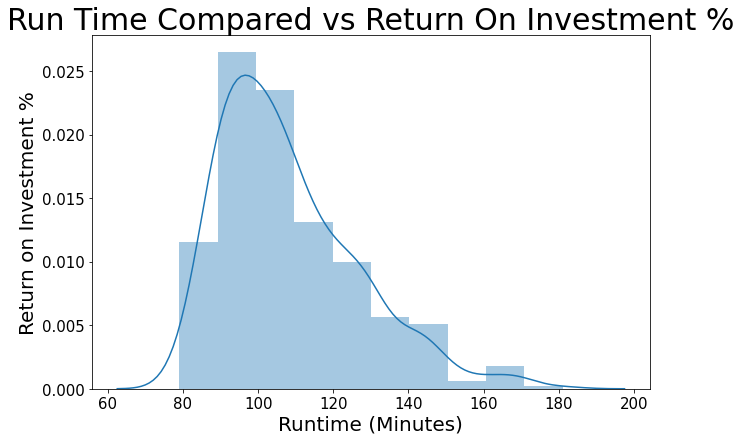

In [15]:
# What would be the optimal runtime of a movie
fig, ax = plt.subplots(figsize=(10, 6.5))
sns.distplot(genre_df['runtimeMinutes'][0:500], bins=10, ax=ax)
ax.set_title("Run Time Compared vs Return On Investment %")
ax.title.set_fontsize(30)
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.xaxis.label.set_text("Runtime (Minutes)")
ax.yaxis.label.set_text("Return on Investment %")
ax.tick_params(axis='both', which='major', labelsize=15)

# A runtime of 90-110 minutes would be ideal

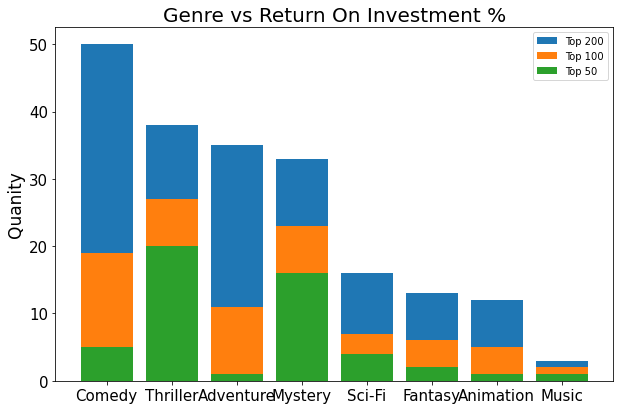

In [16]:
# Which genre would make the most
fig, ax = plt.subplots(figsize=(10, 6.5))
dicta = genre_df['genres'][0:200].value_counts().to_dict()
ax.bar(dicta.keys(), dicta.values())

dicta = genre_df['genres'][0:100].value_counts().to_dict()
ax.bar(dicta.keys(), dicta.values())

dicta = genre_df['genres'][0:50].value_counts().to_dict()
ax.bar(dicta.keys(), dicta.values())

ax.legend(["Top 200", "Top 100", "Top 50"])
ax.set_title("Genre vs Return On Investment %")
ax.title.set_fontsize(20)
ax.yaxis.label.set_fontsize(17)
ax.yaxis.label.set_text("Quanity")
ax.tick_params(axis='both', which='major', labelsize=15)

# Comedy or thriller seem to take the cake

In [17]:
# Creating a dataframe of all the names to pull out director's and writer's names
q2 = """
SELECT *
FROM name_basics
"""
name_df = ps.sqldf(q2, locals())
name_df  # Name Dataframe

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0053137,tt0031983,tt0050419,tt0072308"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0071877,tt0038355,tt0117057,tt0037382"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0054452,tt0057345,tt0059956,tt0049189"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0078723,tt0080455,tt0077975,tt0072562"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0060827,tt0050976,tt0083922,tt0050986"
...,...,...,...,...,...,...
10248840,nm9993714,Romeo del Rosario,\N,\N,"animation_department,art_department",tt2455546
10248841,nm9993716,Essias Loberg,\N,\N,None,\N
10248842,nm9993717,Harikrishnan Rajan,\N,\N,cinematographer,tt8736744
10248843,nm9993718,Aayush Nair,\N,\N,cinematographer,\N


In [18]:
name_df = name_df.set_index('nconst')
name_df

,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
nconst,,,,,
nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0053137,tt0031983,tt0050419,tt0072308"
nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0071877,tt0038355,tt0117057,tt0037382"
nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0054452,tt0057345,tt0059956,tt0049189"
nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0078723,tt0080455,tt0077975,tt0072562"
nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0060827,tt0050976,tt0083922,tt0050986"
...,...,...,...,...,...
nm9993714,Romeo del Rosario,\N,\N,"animation_department,art_department",tt2455546
nm9993716,Essias Loberg,\N,\N,None,\N
nm9993717,Harikrishnan Rajan,\N,\N,cinematographer,tt8736744


In [19]:
director_split_df = genre_df.copy(deep=True)
director_split_df['directors'] = director_split_df['directors'].map(lambda x: x.split(','))
director_split_df['director_count'] = director_split_df['directors'].map(lambda x: len(x))

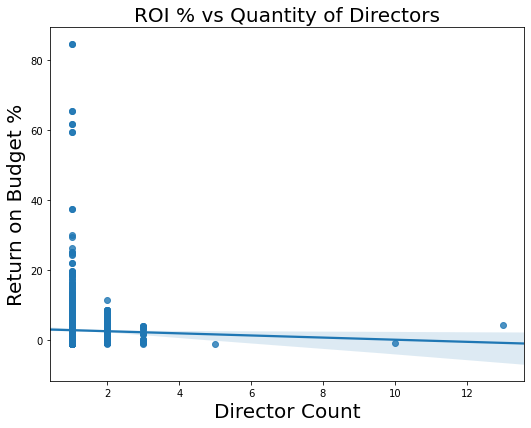

In [20]:
# How many directors would be ideal
fig, ax = plt.subplots(figsize=(8.5, 6.5))
sns.regplot("director_count", "perc", data=director_split_df, ax=ax)
ax.set_title("ROI % vs Quantity of Directors")
ax.title.set_fontsize(20)
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.xaxis.label.set_text("Director Count")
ax.yaxis.label.set_text("Return on Budget %")

# The graph is showing a downward trend the more directors you have
# So 1 director would be the best case.

In [21]:
# Remove movies that have more than one director
director_split_df['director_count'] = director_split_df['director_count'].apply(lambda x: 1 if x == 1 else np.NaN)
director_split_df = director_split_df.dropna()
director_split_df = director_split_df.drop(columns=['director_count'])
director_split_df['directors'] =  director_split_df['directors'].apply(lambda x: x[0])

In [22]:
# Get the top 200 directors that have made more than one movie
x_directors = director_split_df['directors'][0:200].value_counts().apply(lambda x: np.NaN if x < 2 else x).dropna()
x_directors

nm1490123    6.0
nm0796117    5.0
nm1443502    4.0
nm0484907    4.0
nm0440458    3.0
            ... 
nm1720541    2.0
nm1291105    2.0
nm0281508    2.0
nm0795290    2.0
nm0300174    2.0
Name: directors, Length: 63, dtype: float64

In [23]:
# Remove all but said top 200 from df
director_split_df['directors'] = director_split_df['directors'].apply(lambda x: x if x in x_directors else np.NaN)
director_split_df = director_split_df.dropna()
director_split_df

,tconst,primaryTitle,genres,budget,ww_gross,rating,perc,runtimeMinutes,directors,writers
1288,tt7668870,Searching,Thriller,880000,75462037,PG-13,84.752315,102,nm3792134,"nm3792134,nm3539578"
1288,tt7668870,Searching,Mystery,880000,75462037,PG-13,84.752315,102,nm3792134,"nm3792134,nm3539578"
687,tt1591095,Insidious,Thriller,1500000,99557032,PG-13,65.371355,103,nm1490123,nm1191481
687,tt1591095,Insidious,Mystery,1500000,99557032,PG-13,65.371355,103,nm1490123,nm1191481
838,tt3713166,Unfriended,Thriller,1000000,62882090,R,61.882090,83,nm0300174,nm4532532
...,...,...,...,...,...,...,...,...,...,...
11,tt0409847,Cowboys & Aliens,Sci-Fi,163000000,174822325,PG-13,0.072530,119,nm0269463,"nm0649460,nm0476064,nm0511541,nm1318843,nm1319..."
11,tt0409847,Cowboys & Aliens,Thriller,163000000,174822325,PG-13,0.072530,119,nm0269463,"nm0649460,nm0476064,nm0511541,nm1318843,nm1319..."
967,tt4463894,Shaft,Comedy,35000000,21360215,R,-0.389708,111,nm1103162,"nm0862781,nm1244069,nm1113415"
992,tt4572792,The Book of Henry,Thriller,10000000,4596705,PG-13,-0.540330,105,nm1119880,nm3884127


In [24]:
director_dict = {}
for director in director_split_df['directors'].unique():
    director_dict[director] = director_split_df.loc[director_split_df['directors'] == director]['perc'].sum()
director_df = pd.DataFrame(director_dict, index=[0])
director_df = director_df.transpose().reset_index()
director_df.columns=['nconst', 'value']
director_df

,nconst,value
0,nm3792134,169.504630
1,nm1490123,173.048808
2,nm0300174,123.764180
3,nm1443502,142.627735
4,nm0821844,75.147252
...,...,...
58,nm1139726,9.988849
59,nm0000965,14.664250
60,nm0000631,17.501734
61,nm0000881,9.526093


In [25]:
# Add in the real name of each director from name_basics based on nconst
director_df['name'] = director_df['nconst'].apply(lambda x: name_df.loc[x]['primaryName'])
director_df

,nconst,value,name
0,nm3792134,169.504630,Aneesh Chaganty
1,nm1490123,173.048808,James Wan
2,nm0300174,123.764180,Levan Gabriadze
3,nm1443502,142.627735,Jordan Peele
4,nm0821844,75.147252,Daniel Stamm
...,...,...,...
58,nm1139726,9.988849,Neil Burger
59,nm0000965,14.664250,Danny Boyle
60,nm0000631,17.501734,Ridley Scott
61,nm0000881,9.526093,Michael Bay


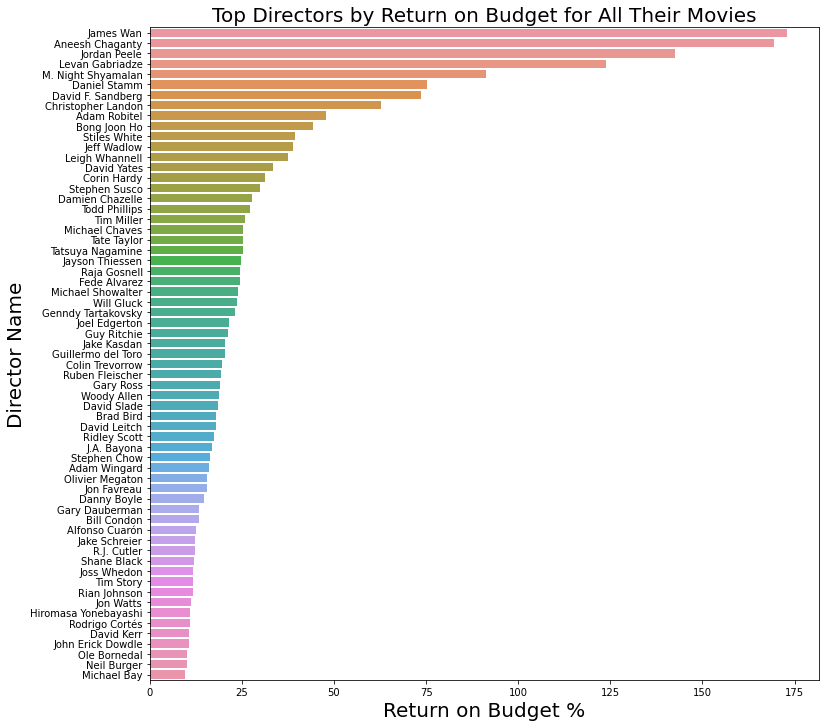

In [26]:
# Which directors would be ideal to hire
fig, ax = plt.subplots(figsize=(12, 12))
sns.barplot('value', 'name', data=director_df.sort_values(by='value', ascending=False), ax=ax)
ax.set_title("Top Directors by Return on Budget for All Their Movies")
ax.title.set_fontsize(20)
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.xaxis.label.set_text("Return on Budget %")
ax.yaxis.label.set_text("Director Name")

# Here are the top 60 directors

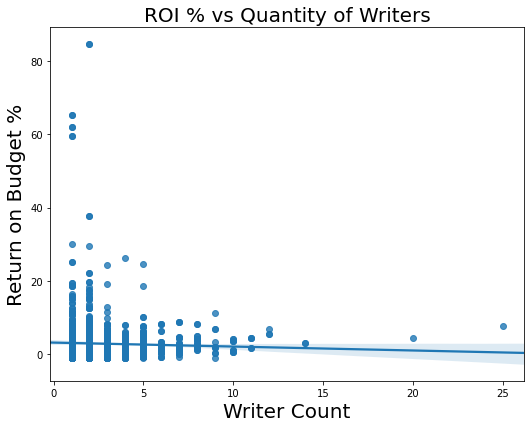

In [27]:
# How many writers would be ideal
writer_split_df = genre_df.copy(deep=True)
writer_split_df['writers'] = writer_split_df['writers'].map(lambda x: x.split(','))
writer_split_df['writer_count'] = writer_split_df['writers'].map(lambda x: len(x))

fig, ax = plt.subplots(figsize=(8.5, 6.5))
sns.regplot("writer_count", "perc", data=writer_split_df, ax=ax)
ax.set_title("ROI % vs Quantity of Writers")
ax.title.set_fontsize(20)
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.xaxis.label.set_text("Writer Count")
ax.yaxis.label.set_text("Return on Budget %")
# The graph is showing a downward trend the more writers you have
# So 1 writer would be the best case.

In [28]:
# Parse and remove movies with more than one writer
writer_split_df['writer_count'] = writer_split_df['writer_count'].apply(lambda x: 1 if x == 1 else np.NaN)
writer_split_df = writer_split_df.dropna()
writer_split_df = writer_split_df.drop(columns=['writer_count'])
writer_split_df['writers'] =  writer_split_df['writers'].apply(lambda x: x[0])
# Create a list of writers that have written more than one movie
x_writers = writer_split_df['writers'][0:200].value_counts().apply(lambda x: np.NaN if x < 2 else x).dropna()
x_writers

nm0796117    6.0
nm0000095    5.0
nm1191481    5.0
nm1347153    5.0
nm1443502    4.0
nm2752098    3.0
nm0831557    3.0
nm0009190    3.0
nm2704527    3.0
nm1108556    3.0
nm0191717    3.0
nm1959505    3.0
nm0839812    2.0
nm0797321    2.0
nm1245146    2.0
nm1098493    2.0
nm0204030    2.0
nm1440023    2.0
nm4170048    2.0
nm1557594    2.0
nm4532532    2.0
nm0746830    2.0
nm0472567    2.0
nm0424901    2.0
nm0001675    2.0
nm0934483    2.0
nm2477891    2.0
nm0426059    2.0
nm0847859    2.0
nm0634240    2.0
nm0159900    2.0
nm0307497    2.0
nm2133655    2.0
nm0642277    2.0
nm5429637    2.0
nm0249291    2.0
nm0083348    2.0
nm0629272    2.0
nm3398282    2.0
nm0567620    2.0
nm0426500    2.0
nm1867458    2.0
nm0776885    2.0
nm0868066    2.0
nm0218621    2.0
nm3227090    2.0
nm0792263    2.0
Name: writers, dtype: float64

In [29]:
# Get top movies with one writer who has written more than one movie
writer_split_df['writers'] = writer_split_df['writers'].apply(lambda x: x if x in x_writers else np.NaN)
writer_split_df = writer_split_df.dropna()
writer_split_df

,tconst,primaryTitle,genres,budget,ww_gross,rating,perc,runtimeMinutes,directors,writers
687,tt1591095,Insidious,Thriller,1500000,99557032,PG-13,65.371355,103,nm1490123,nm1191481
687,tt1591095,Insidious,Mystery,1500000,99557032,PG-13,65.371355,103,nm1490123,nm1191481
838,tt3713166,Unfriended,Thriller,1000000,62882090,R,61.882090,83,nm0300174,nm4532532
838,tt3713166,Unfriended,Mystery,1000000,62882090,R,61.882090,83,nm0300174,nm4532532
1074,tt5052448,Get Out,Thriller,4500000,272495873,R,59.554638,104,nm1443502,nm1443502
...,...,...,...,...,...,...,...,...,...,...
1130,tt5610554,Tully,Comedy,13000000,15636462,R,0.202805,95,nm0718646,nm1959505
1130,tt5610554,Tully,Mystery,13000000,15636462,R,0.202805,95,nm0718646,nm1959505
1207,tt6348138,Missing Link,Animation,100000000,26249469,PG,-0.737505,93,nm2752098,nm2752098
1207,tt6348138,Missing Link,Adventure,100000000,26249469,PG,-0.737505,93,nm2752098,nm2752098


In [30]:
writer_dict = {}
# Get the values for each writer, based on overall ROI %
for writer in writer_split_df['writers'].unique():
    writer_dict[writer] = writer_split_df.loc[writer_split_df['writers'] == writer]['perc'].sum()
writer_df = pd.DataFrame(writer_dict, index=[0])
writer_df = writer_df.transpose().reset_index()
writer_df.columns=['nconst', 'value']
writer_df

,nconst,value
0,nm1191481,164.648328
1,nm4532532,123.764180
2,nm1443502,142.627735
3,nm0796117,91.150728
4,nm1245146,50.283028
5,nm2477891,38.868785
6,nm0839812,30.049974
7,nm3227090,27.765748
8,nm0868066,25.190732
9,nm3398282,22.442269


In [31]:
# Add in the names of said writers from name_basics
writer_df['name'] = writer_df['nconst'].apply(lambda x: name_df.loc[x]['primaryName'])
writer_df

,nconst,value,name
0,nm1191481,164.648328,Leigh Whannell
1,nm4532532,123.764180,Nelson Greaves
2,nm1443502,142.627735,Jordan Peele
3,nm0796117,91.150728,M. Night Shyamalan
4,nm1245146,50.283028,Scott Lobdell
5,nm2477891,38.868785,Gary Dauberman
6,nm0839812,30.049974,Stephen Susco
7,nm3227090,27.765748,Damien Chazelle
8,nm0868066,25.190732,Akira Toriyama
9,nm3398282,22.442269,Scotty Landes


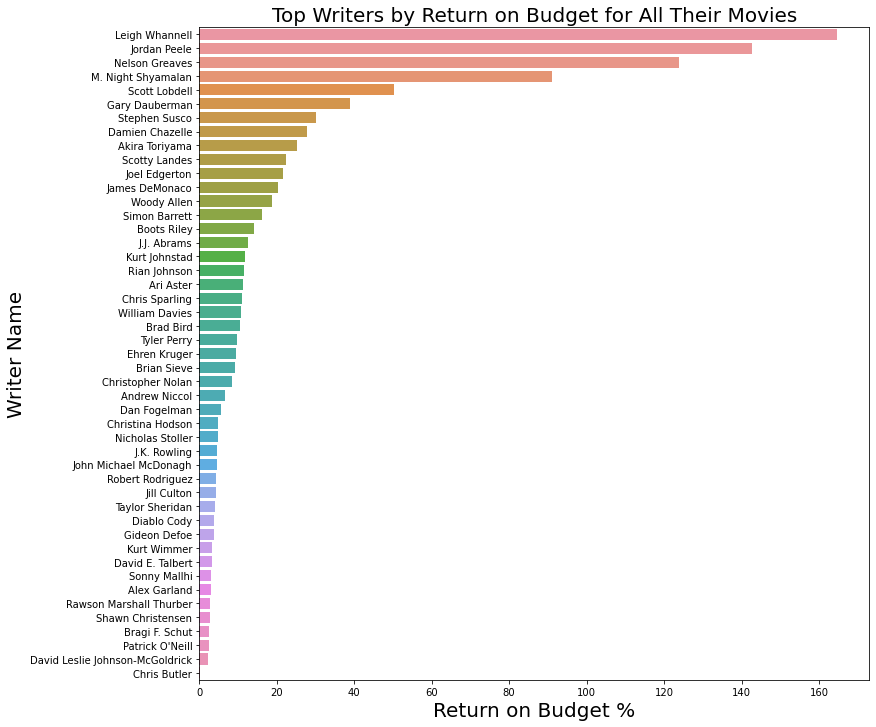

In [32]:
# Which writers would be best
fig, ax = plt.subplots(figsize=(12, 12))
sns.barplot('value', 'name', data=writer_df.sort_values(by='value', ascending=False), ax=ax)
ax.set_title("Top Writers by Return on Budget for All Their Movies")
ax.title.set_fontsize(20)
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.xaxis.label.set_text("Return on Budget %")
ax.yaxis.label.set_text("Writer Name")

# Here are the top 60 writers

In [33]:
# Top 10 writers
writer_df[0:10]

,nconst,value,name
0,nm1191481,164.648328,Leigh Whannell
1,nm4532532,123.764180,Nelson Greaves
2,nm1443502,142.627735,Jordan Peele
3,nm0796117,91.150728,M. Night Shyamalan
4,nm1245146,50.283028,Scott Lobdell
5,nm2477891,38.868785,Gary Dauberman
6,nm0839812,30.049974,Stephen Susco
7,nm3227090,27.765748,Damien Chazelle
8,nm0868066,25.190732,Akira Toriyama
9,nm3398282,22.442269,Scotty Landes


In [34]:
# Top 10 directors
director_df[0:10]

,nconst,value,name
0,nm3792134,169.504630,Aneesh Chaganty
1,nm1490123,173.048808,James Wan
2,nm0300174,123.764180,Levan Gabriadze
3,nm1443502,142.627735,Jordan Peele
4,nm0821844,75.147252,Daniel Stamm
5,nm0796117,91.150728,M. Night Shyamalan
6,nm2497546,73.569613,David F. Sandberg
7,nm0905592,38.927414,Jeff Wadlow
8,nm0484907,62.638617,Christopher Landon
9,nm0094435,44.365252,Bong Joon Ho


In [35]:
# Best movie would be worldwide
# directed and written by one of the top 10
# rated PG-13 or R
# either a comedy or a thriller
# being 90-110 minutes long